In [538]:
# for data manipulation
import pandas as pd
import numpy as np
# for plotting
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go # note that github wont be able to display these plots because they are interactive
# for some processing
import math
from datetime import datetime, timedelta

In [539]:
folder = "/kaggle/input/asna-september-2024/"
df = pd.read_csv(folder + "train.csv")
df = df.drop(columns = ["CustomerID", "Coverage", "Education", "Employment Status", "Marital Status", "Policy Type", "Policy", "Sales Channel", "Vehicle Size"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7290 entries, 0 to 7289
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   State                          7290 non-null   object 
 1   Customer Lifetime Value        7290 non-null   float64
 2   Response                       7290 non-null   object 
 3   Coverage Index                 7290 non-null   int64  
 4   Education Index                7290 non-null   int64  
 5   Effective To Date              7290 non-null   object 
 6   Employment Status Index        7290 non-null   int64  
 7   Gender                         7290 non-null   object 
 8   Income                         7290 non-null   int64  
 9   Marital Status Index           7290 non-null   int64  
 10  Months Since Last Claim        7290 non-null   int64  
 11  Months Since Policy Inception  7290 non-null   int64  
 12  Number of Open Complaints      7290 non-null   i

In [540]:
df["Claim over 1k"].value_counts()

Claim over 1k
0    6458
1     832
Name: count, dtype: int64

In [541]:
df = df.sample(frac=1).reset_index(drop=True)
number_of_test_cases = 900
df_test_from_train = df.head(number_of_test_cases).copy()
df_train = df.tail(len(df) - number_of_test_cases).copy()

In [542]:
def pre_process(df):
  # State
  unique_states = df["State"].unique()
  dict_states = {}
  for i in range(len(unique_states)):
    dict_states[unique_states[i]] = i
  df["State"] = df["State"].apply(lambda x: dict_states[x])
  
  # Response
  # note that resonse should be either yes or no
  df["Response"] = df["Response"].apply(lambda x: 1 if x == "Yes" else 0)

  # Effective To Date
  df["Effective To Date"] = pd.to_datetime(df["Effective To Date"])
  today = pd.Timestamp.today()
  df["Effective Days"] = (today - df["Effective To Date"]).dt.days
  # drop the date columns
  df.drop("Effective To Date", axis = 1, inplace=True)
  # Gender
  df["Gender"] = df["Gender"].apply(lambda x: 1 if x == "M" else 0)

In [543]:
pre_process(df_train)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6390 entries, 900 to 7289
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   State                          6390 non-null   int64  
 1   Customer Lifetime Value        6390 non-null   float64
 2   Response                       6390 non-null   int64  
 3   Coverage Index                 6390 non-null   int64  
 4   Education Index                6390 non-null   int64  
 5   Employment Status Index        6390 non-null   int64  
 6   Gender                         6390 non-null   int64  
 7   Income                         6390 non-null   int64  
 8   Marital Status Index           6390 non-null   int64  
 9   Months Since Last Claim        6390 non-null   int64  
 10  Months Since Policy Inception  6390 non-null   int64  
 11  Number of Open Complaints      6390 non-null   int64  
 12  Number of Policies             6390 non-null  

In [544]:
pre_process(df_test_from_train)
df_test_from_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   State                          900 non-null    int64  
 1   Customer Lifetime Value        900 non-null    float64
 2   Response                       900 non-null    int64  
 3   Coverage Index                 900 non-null    int64  
 4   Education Index                900 non-null    int64  
 5   Employment Status Index        900 non-null    int64  
 6   Gender                         900 non-null    int64  
 7   Income                         900 non-null    int64  
 8   Marital Status Index           900 non-null    int64  
 9   Months Since Last Claim        900 non-null    int64  
 10  Months Since Policy Inception  900 non-null    int64  
 11  Number of Open Complaints      900 non-null    int64  
 12  Number of Policies             900 non-null    int

In [545]:
df_test_from_train["Claim over 1k"].value_counts()

Claim over 1k
0    811
1     89
Name: count, dtype: int64

In [546]:
# def process_state(df):
#   unique_states = df["State"].unique()
#   dict_states = {}
#   for i in range(len(unique_states)):
#     dict_states[unique_states[i]] = i
#   df["State"] = df["State"].apply(lambda x: dict_states[x])
# process_state(df_train)

In [547]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.utils import resample

In [548]:
import math

def plot_np(X, names, ax):
  m, n = X.shape
  for index in range(n):
    col = X[:, index]
    i, j = index // 2, index % 2
    ax[i, j].hist(col, bins=10, edgecolor="black")
    ax[i, j].set_title(f"{names[index]}")

def plot_df(df):
  X = np.array(df)
  m, n = X.shape
  number_of_row = math.ceil(n / 2)
  # plot subplots
  fig, ax = plt.subplots(number_of_row, 2, figsize=(20,30))
  plot_np(X, df.columns, ax)
  # plot
  plt.tight_layout()
  plt.show()

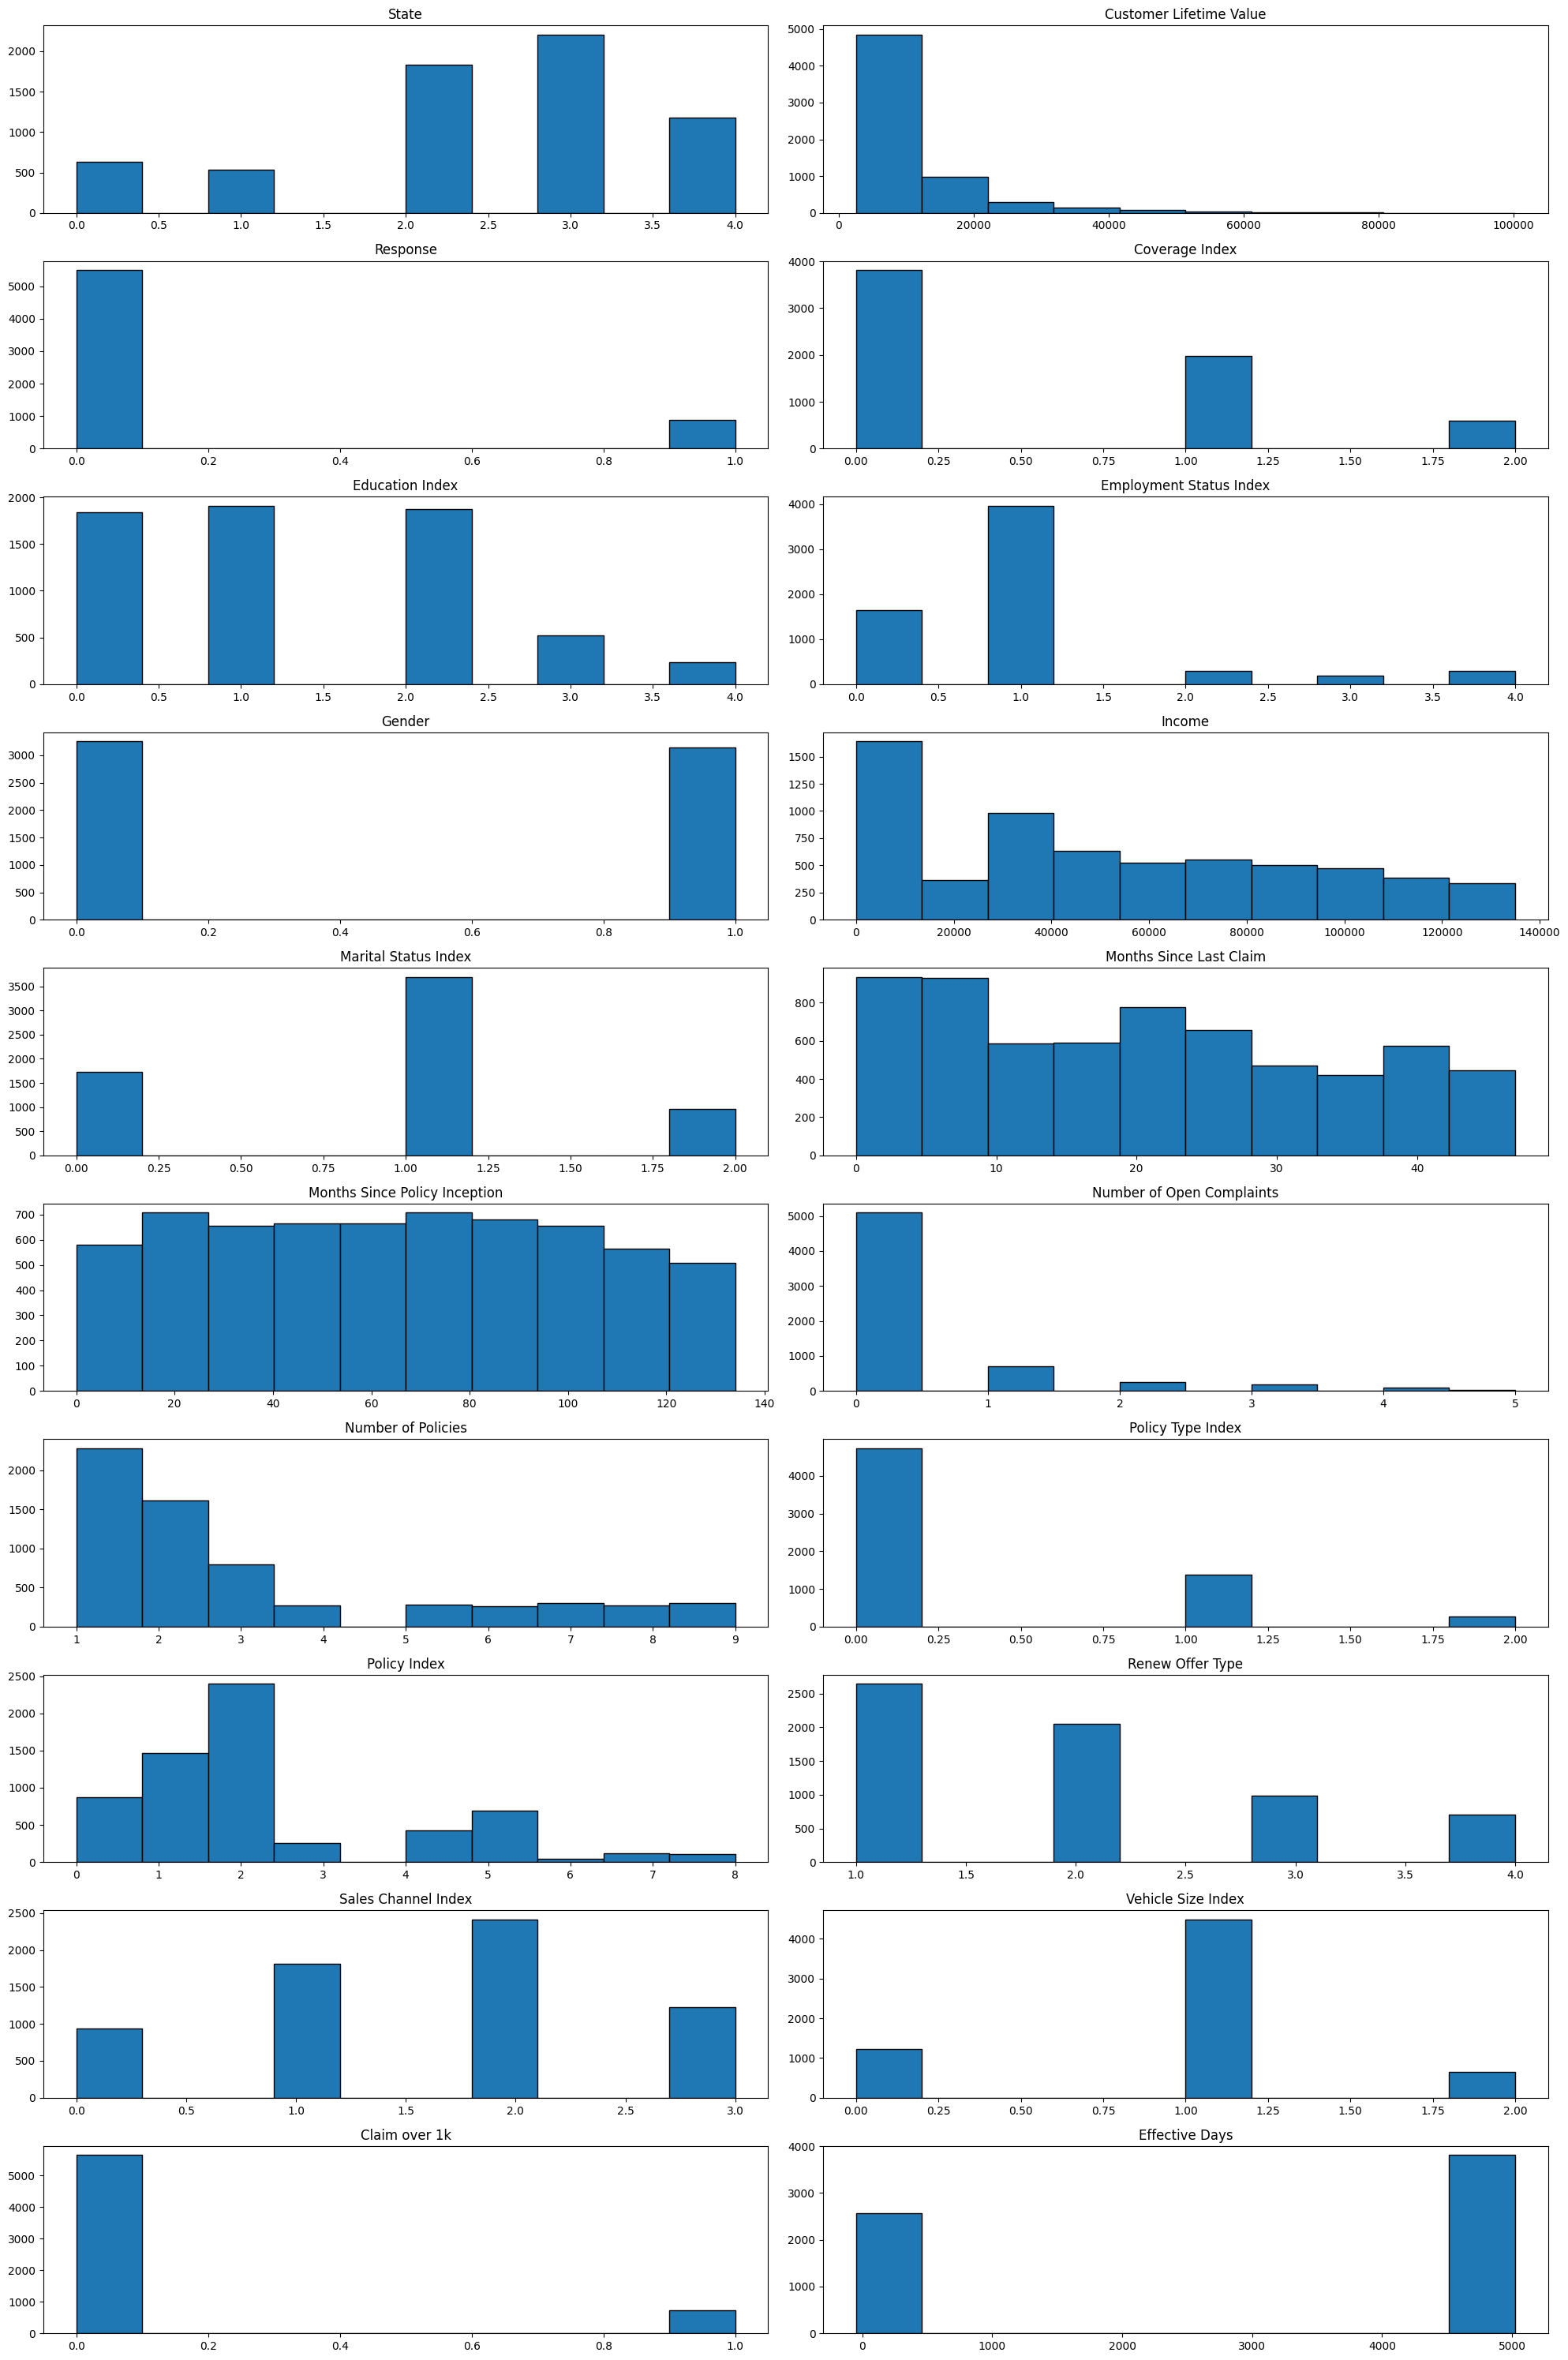

In [549]:
plot_df(df_train)

In [584]:

def relation_to_claim_over_1k(df):
    plt.figure(figsize=(30, 80))
    numerical_cols = df.columns.tolist()
    not_include = ["Customer Lifetime Value", "Income", "Claim over 1k"]
    numerical_cols = [col for col in numerical_cols if col not in not_include]
    
    for i, col in enumerate(numerical_cols):
        print(col)
#         plt.subplot(len(numerical_cols), 1, i + 1)
        fig = go.Figure()
        print(df.groupby(col)["Claim over 1k"].value_counts().reset_index())
        df_count = df.groupby(col)["Claim over 1k"].value_counts().reset_index()
        unique_val = df_count[col].unique()
        for val in unique_val:
            df_cur = df_count[df_count[col] == val]
            fig.add_trace(
                go.Bar(
                    x = df_cur["Claim over 1k"],
                    y = df_cur["count"],
                )
            )
        fig.show()
#         plt.title(col)
    plt.tight_layout()
    plt.show()
relation_to_claim_over_1k(df_train)

State
   State  Claim over 1k  count
0      0              0    565
1      0              1     67
2      1              0    472
3      1              1     62
4      2              0   1614
5      2              1    222
6      3              0   1934
7      3              1    272
8      4              0   1062
9      4              1    120


Response
   Response  Claim over 1k  count
0         0              0   4831
1         0              1    670
2         1              0    816
3         1              1     73


Coverage Index
   Coverage Index  Claim over 1k  count
0               0              0   3529
1               0              1    287
2               1              0   1726
3               1              1    247
4               2              0    392
5               2              1    209


Education Index
   Education Index  Claim over 1k  count
0                0              0   1547
1                0              1    290
2                1              0   1719
3                1              1    192
4                2              0   1655
5                2              1    223
6                3              0    494
7                3              1     32
8                4              0    232
9                4              1      6


Employment Status Index
   Employment Status Index  Claim over 1k  count
0                        0              0   1234
1                        0              1    407
2                        1              0   3719
3                        1              1    252
4                        2              0    254
5                        2              1     36
6                        3              0    177
7                        3              1     13
8                        4              0    263
9                        4              1     35


Gender
   Gender  Claim over 1k  count
0       0              0   2942
1       0              1    313
2       1              0   2705
3       1              1    430


Marital Status Index
   Marital Status Index  Claim over 1k  count
0                     0              0   1324
1                     0              1    405
2                     1              0   3429
3                     1              1    268
4                     2              0    894
5                     2              1     70


Months Since Last Claim
    Months Since Last Claim  Claim over 1k  count
0                         0              0    191
1                         0              1     22
2                         1              0    207
3                         1              1     25
4                         3              0    195
..                      ...            ...    ...
67                       45              1     16
68                       46              0    104
69                       46              1     11
70                       47              0     89
71                       47              1     14

[72 rows x 3 columns]


Months Since Policy Inception
     Months Since Policy Inception  Claim over 1k  count
0                                0              0     48
1                                0              1      7
2                                1              0     54
3                                1              1      8
4                                3              0     48
..                             ...            ...    ...
195                            131              1      2
196                            132              0     36
197                            132              1      2
198                            134              0     42
199                            134              1      7

[200 rows x 3 columns]


Number of Open Complaints
    Number of Open Complaints  Claim over 1k  count
0                           0              0   4505
1                           0              1    596
2                           1              0    625
3                           1              1     81
4                           2              0    223
5                           2              1     25
6                           3              0    180
7                           3              1     18
8                           4              0     80
9                           4              1     17
10                          5              0     34
11                          5              1      6


Number of Policies
    Number of Policies  Claim over 1k  count
0                    1              0   2003
1                    1              1    280
2                    2              0   1436
3                    2              1    182
4                    3              0    728
5                    3              1     72
6                    4              0    239
7                    4              1     36
8                    5              0    252
9                    5              1     32
10                   6              0    228
11                   6              1     30
12                   7              0    254
13                   7              1     46
14                   8              0    234
15                   8              1     40
16                   9              0    273
17                   9              1     25


Policy Type Index
   Policy Type Index  Claim over 1k  count
0                  0              0   4186
1                  0              1    551
2                  1              0   1224
3                  1              1    155
4                  2              0    237
5                  2              1     37


Policy Index
    Policy Index  Claim over 1k  count
0              0              0    763
1              0              1    106
2              1              0   1300
3              1              1    170
4              2              0   2123
5              2              1    275
6              3              0    231
7              3              1     30
8              4              0    378
9              4              1     47
10             5              0    615
11             5              1     78
12             6              0     39
13             6              1     10
14             7              0    101
15             7              1     14
16             8              0     97
17             8              1     13


Renew Offer Type
   Renew Offer Type  Claim over 1k  count
0                 1              0   2270
1                 1              1    375
2                 2              0   1866
3                 2              1    184
4                 3              0    872
5                 3              1    114
6                 4              0    639
7                 4              1     70


Sales Channel Index
   Sales Channel Index  Claim over 1k  count
0                    0              0    836
1                    0              1    102
2                    1              0   1593
3                    1              1    221
4                    2              0   2132
5                    2              1    283
6                    3              0   1086
7                    3              1    137


Vehicle Size Index
   Vehicle Size Index  Claim over 1k  count
0                   0              0   1066
1                   0              1    171
2                   1              0   3997
3                   1              1    497
4                   2              0    584
5                   2              1     75


Effective Days
     Effective Days  Claim over 1k  count
0               -48              0     87
1               -48              1     14
2               -47              0     77
3               -47              1      8
4               -18              0     89
..              ...            ...    ...
113            5022              1     13
114            5023              0     94
115            5023              1     14
116            5024              0     74
117            5024              1     15

[118 rows x 3 columns]


<Figure size 3000x8000 with 0 Axes>

In [592]:
def balance(df):
  df_majority = df[df["Claim over 1k"] == 0]
  df_minority = df[df["Claim over 1k"] == 1]
  # Upsample minority class
  df_minority_upsampled = resample(df_minority,
                                    replace=True,  # Sample with replacement
                                    n_samples=len(df_majority),  # Match the majority class
                                    random_state=42)  # Reproducible results

  # Combine majority class with upsampled minority class
  df_balanced = pd.concat([df_majority, df_minority_upsampled])
  print(df_balanced["Claim over 1k"].value_counts())
  relation_to_claim_over_1k(df_balanced)
  from imblearn.over_sampling import SMOTE

  X = df_balanced.drop(columns=['Claim over 1k'])  # Features
  y = df_balanced['Claim over 1k']  # Target

  smote = SMOTE(random_state=42)
  X_resampled, y_resampled = smote.fit_resample(X, y)
  return X_resampled, y_resampled

In [593]:
# X = df_train.drop("Claim over 1k", axis = 1)
# y = df_train["Claim over 1k"]

X_resampled, y_resampled = balance(df_train)

Claim over 1k
0    5647
1    5647
Name: count, dtype: int64
State
   State  Claim over 1k  count
0      0              0    565
1      0              1    512
2      1              1    475
3      1              0    472
4      2              1   1681
5      2              0   1614
6      3              1   2104
7      3              0   1934
8      4              0   1062
9      4              1    875


Response
   Response  Claim over 1k  count
0         0              1   5040
1         0              0   4831
2         1              0    816
3         1              1    607


Coverage Index
   Coverage Index  Claim over 1k  count
0               0              0   3529
1               0              1   2155
2               1              1   1933
3               1              0   1726
4               2              1   1559
5               2              0    392


Education Index
   Education Index  Claim over 1k  count
0                0              1   2228
1                0              0   1547
2                1              0   1719
3                1              1   1459
4                2              1   1665
5                2              0   1655
6                3              0    494
7                3              1    256
8                4              0    232
9                4              1     39


Employment Status Index
   Employment Status Index  Claim over 1k  count
0                        0              1   3165
1                        0              0   1234
2                        1              0   3719
3                        1              1   1864
4                        2              1    258
5                        2              0    254
6                        3              0    177
7                        3              1     96
8                        4              1    264
9                        4              0    263


Gender
   Gender  Claim over 1k  count
0       0              0   2942
1       0              1   2413
2       1              1   3234
3       1              0   2705


Marital Status Index
   Marital Status Index  Claim over 1k  count
0                     0              1   3168
1                     0              0   1324
2                     1              0   3429
3                     1              1   1973
4                     2              0    894
5                     2              1    506


Months Since Last Claim
    Months Since Last Claim  Claim over 1k  count
0                         0              0    191
1                         0              1    171
2                         1              0    207
3                         1              1    194
4                         3              1    198
..                      ...            ...    ...
67                       45              0    109
68                       46              0    104
69                       46              1     94
70                       47              1    113
71                       47              0     89

[72 rows x 3 columns]


Months Since Policy Inception
     Months Since Policy Inception  Claim over 1k  count
0                                0              0     48
1                                0              1     44
2                                1              0     54
3                                1              1     53
4                                3              0     48
..                             ...            ...    ...
195                            131              1     15
196                            132              0     36
197                            132              1     20
198                            134              1     52
199                            134              0     42

[200 rows x 3 columns]


Number of Open Complaints
    Number of Open Complaints  Claim over 1k  count
0                           0              0   4505
1                           0              1   4468
2                           1              1    631
3                           1              0    625
4                           2              0    223
5                           2              1    210
6                           3              0    180
7                           3              1    151
8                           4              1    130
9                           4              0     80
10                          5              1     57
11                          5              0     34


Number of Policies
    Number of Policies  Claim over 1k  count
0                    1              1   2131
1                    1              0   2003
2                    2              0   1436
3                    2              1   1409
4                    3              0    728
5                    3              1    562
6                    4              0    239
7                    4              1    235
8                    5              0    252
9                    5              1    216
10                   6              1    232
11                   6              0    228
12                   7              1    376
13                   7              0    254
14                   8              1    296
15                   8              0    234
16                   9              0    273
17                   9              1    190


Policy Type Index
   Policy Type Index  Claim over 1k  count
0                  0              0   4186
1                  0              1   4159
2                  1              1   1229
3                  1              0   1224
4                  2              1    259
5                  2              0    237


Policy Index
    Policy Index  Claim over 1k  count
0              0              1    817
1              0              0    763
2              1              0   1300
3              1              1   1245
4              2              0   2123
5              2              1   2097
6              3              1    290
7              3              0    231
8              4              0    378
9              4              1    375
10             5              0    615
11             5              1    564
12             6              1     77
13             6              0     39
14             7              0    101
15             7              1     97
16             8              0     97
17             8              1     85


Renew Offer Type
   Renew Offer Type  Claim over 1k  count
0                 1              1   2828
1                 1              0   2270
2                 2              0   1866
3                 2              1   1428
4                 3              0    872
5                 3              1    853
6                 4              0    639
7                 4              1    538


Sales Channel Index
   Sales Channel Index  Claim over 1k  count
0                    0              0    836
1                    0              1    749
2                    1              1   1602
3                    1              0   1593
4                    2              1   2183
5                    2              0   2132
6                    3              1   1113
7                    3              0   1086


Vehicle Size Index
   Vehicle Size Index  Claim over 1k  count
0                   0              1   1304
1                   0              0   1066
2                   1              0   3997
3                   1              1   3796
4                   2              0    584
5                   2              1    547


Effective Days
     Effective Days  Claim over 1k  count
0               -48              1    111
1               -48              0     87
2               -47              0     77
3               -47              1     49
4               -18              0     89
..              ...            ...    ...
113            5022              0     86
114            5023              1    130
115            5023              0     94
116            5024              1    107
117            5024              0     74

[118 rows x 3 columns]


<Figure size 3000x8000 with 0 Axes>

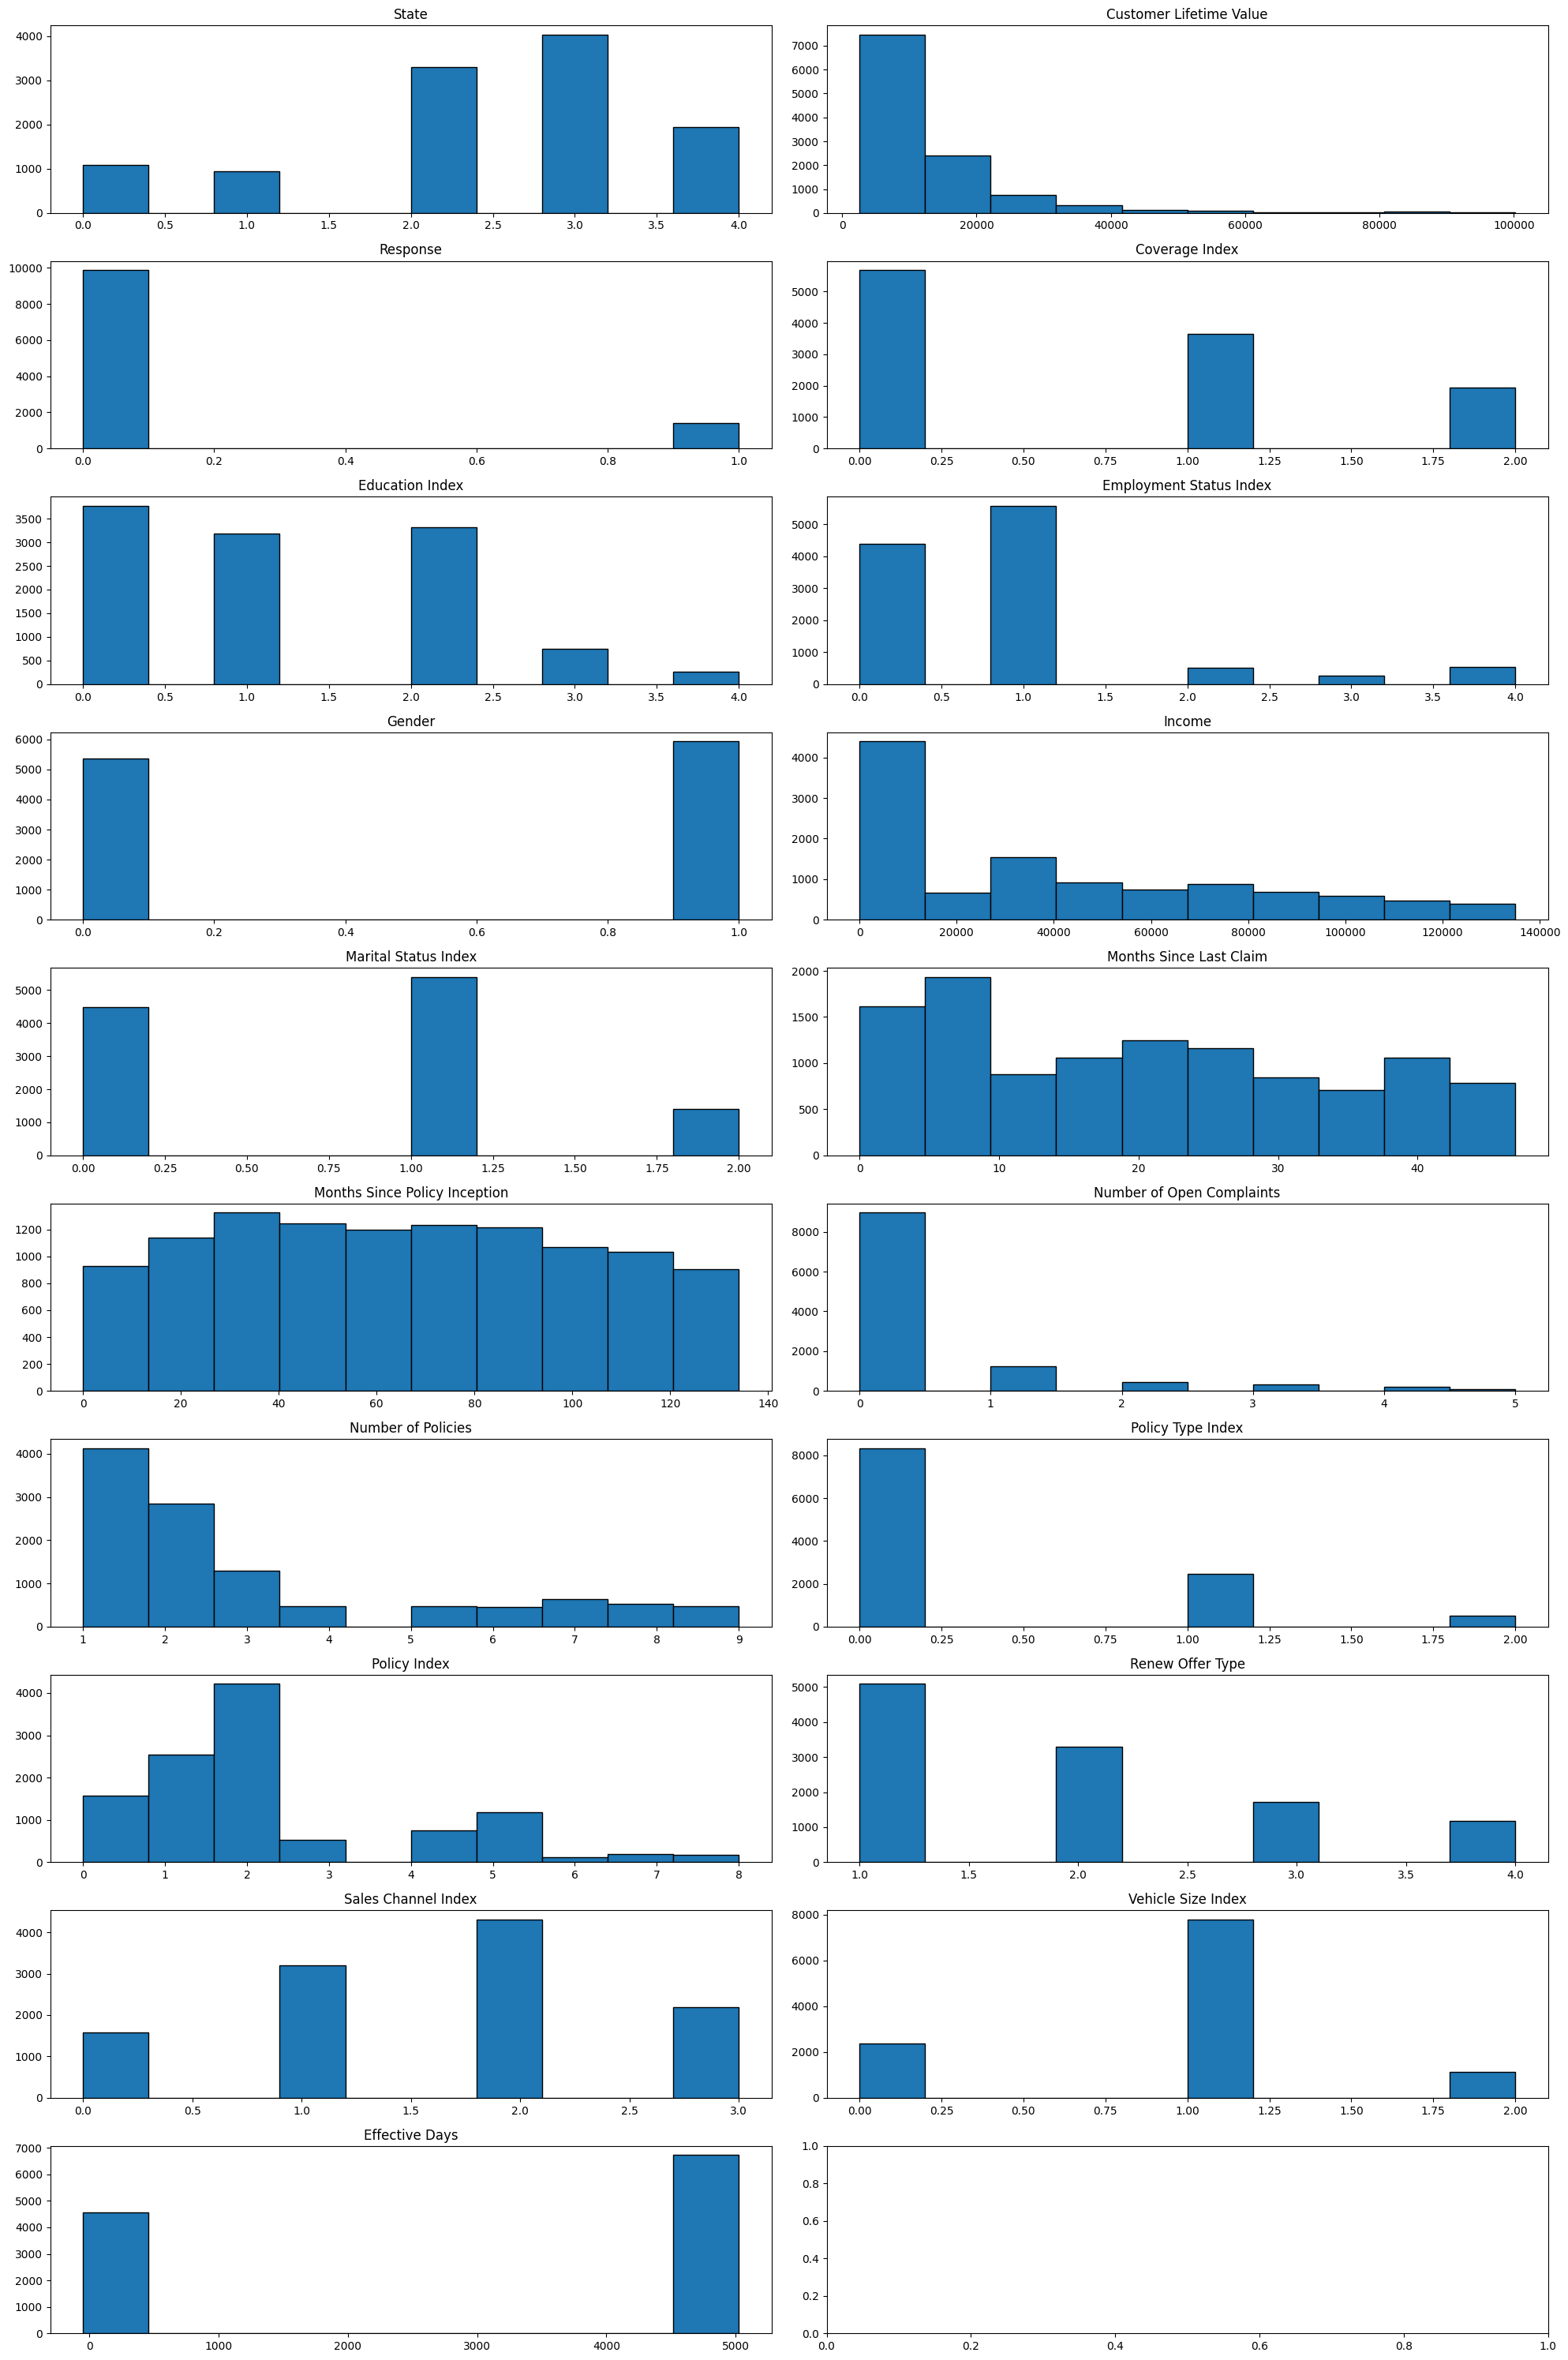

In [553]:
plot_df(X_resampled)

In [554]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.1, random_state = 42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [555]:
def test_monitor(model, X, y):
    # Predict the test set
    y_pred = model.predict(X)
    print("h", X.shape, y_pred.shape)
    # Evaluate the model
    accuracy = accuracy_score(y, y_pred)
    conf_matrix = confusion_matrix(y, y_pred).T
    class_report = classification_report(y, y_pred)

    # Calculate accuracy and F1 score
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    f1 = f1_score(y, y_pred)
    print(f"f1 score: ${f1}")
    
    #            Actual
    #             0   1
    # Predict 0   TP  FP
    #         1   FN  TN
    # Evaluate the model
    tp, fp, fn, tn = conf_matrix.ravel()
    # Calculate sensitivity and specificity
    sensitivity = tp / (tp + fn)  # True Positive Rate
    specificity = tn / (tn + fp)  # True Negative Rate

    print("Sensitivity (Recall):", sensitivity)
    print("Specificity:", specificity)

In [556]:
def neural_network():
  model = MLPClassifier(hidden_layer_sizes=(16, 8, 2), max_iter=1000, random_state=42)
  model.fit(X_train_scaled, y_train)

  test_monitor(model, X_test_scaled, y_test)

  old_X = df_test_from_train.drop("Claim over 1k", axis=1)
  old_y = df_test_from_train["Claim over 1k"]
  test_monitor(model, old_X, old_y)
neural_network()

h (1130, 19) (1130,)
Accuracy: 0.9053097345132743
Confusion Matrix:
[[494  49]
 [ 58 529]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       552
           1       0.90      0.92      0.91       578

    accuracy                           0.91      1130
   macro avg       0.91      0.91      0.91      1130
weighted avg       0.91      0.91      0.91      1130

f1 score: $0.9081545064377683
Sensitivity (Recall): 0.894927536231884
Specificity: 0.9152249134948097
h (900, 19) (900,)
Accuracy: 0.09888888888888889
Confusion Matrix:
[[  0   0]
 [811  89]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       811
           1       0.10      1.00      0.18        89

    accuracy                           0.10       900
   macro avg       0.05      0.50      0.09       900
weighted avg       0.01      0.10      0.02       900

f1 score: $0.1799

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but MLPClassifier was fitted without feature names

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [557]:
def logistics_regression():
  # Initialize Logistic Regression model
  log_reg = LogisticRegression()

  # Train the model on the training data
  log_reg.fit(X_train_scaled, y_train)

  # Make predictions on the test data
  y_pred = log_reg.predict(X_test_scaled)

  # Evaluate the model
  accuracy = accuracy_score(y_test, y_pred)
  conf_matrix = confusion_matrix(y_test, y_pred)
  class_report = classification_report(y_test, y_pred)

  print(f"Accuracy: {accuracy}")
  print("Confusion Matrix:")
  print(conf_matrix)
  print("Classification Report:")
  print(class_report)
  f1 = f1_score(y_test, y_pred)
  print(f1)
logistics_regression()

Accuracy: 0.7424778761061946
Confusion Matrix:
[[407 145]
 [146 432]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.74      0.74       552
           1       0.75      0.75      0.75       578

    accuracy                           0.74      1130
   macro avg       0.74      0.74      0.74      1130
weighted avg       0.74      0.74      0.74      1130

0.7480519480519481


In [636]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=150, criterion="entropy", random_state=42, class_weight = 'balanced', max_depth=32, min_samples_split=5, min_samples_leaf=15, bootstrap=True)

# Train the model on the training data
# Note that random forest is a decision tree (if-else statment on each node), so the data does not have to be scaled
rf_classifier.fit(X_train_scaled, y_train)

test_monitor(rf_classifier, X_test_scaled, y_test)
df_new = df_test_from_train.drop(columns = cols_to_drop, axis = 1)
old_X = df_new.drop("Claim over 1k", axis=1)
old_X_scaled = scaler.fit_transform(old_X)
print(old_X.shape)
old_y = df_new["Claim over 1k"]
test_monitor(rf_classifier, old_X_scaled, old_y)

h (1130, 12) (1130,)
Accuracy: 0.8858407079646018
Confusion Matrix:
[[502  79]
 [ 50 499]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.89       552
           1       0.91      0.86      0.89       578

    accuracy                           0.89      1130
   macro avg       0.89      0.89      0.89      1130
weighted avg       0.89      0.89      0.89      1130

f1 score: $0.8855368234250223
Sensitivity (Recall): 0.9094202898550725
Specificity: 0.8633217993079585
(900, 12)
h (900, 12) (900,)
Accuracy: 0.8411111111111111
Confusion Matrix:
[[692  24]
 [119  65]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.85      0.91       811
           1       0.35      0.73      0.48        89

    accuracy                           0.84       900
   macro avg       0.66      0.79      0.69       900
weighted avg       0.91      0.84      0.86       900

f1 scor

In [559]:
def hyper_tune_random_forest():
    # Step 2: Define the model
    rf_classifier = RandomForestClassifier(random_state=42)

    # Step 3: Specify hyperparameters to tune
    param_grid = {
        'n_estimators': [50, 100, 200],          # Number of trees
        'max_depth': [None, 10,],         # Maximum depth of the trees
        'min_samples_split': [10, 15],         # Minimum samples to split an internal node
        'min_samples_leaf': [10, 15],           # Minimum samples at a leaf node
    }

    # Step 4: Set up GridSearchCV
    grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid,
                               cv=5, n_jobs=-1, verbose=2, scoring='f1')

    # Step 5: Fit the model
    grid_search.fit(X_train, y_train)

    # Step 6: Evaluate the best model
    best_model = grid_search.best_estimator_
    
    return best_model

model = hyper_tune_random_forest()

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [560]:
print(model)
def see_hyper_tune_random_forest():
    old_X = df_test_from_train.drop("Claim over 1k", axis=1)
    print(old_X.shape)
    old_y = df_test_from_train["Claim over 1k"]
    test_monitor(model, old_X, old_y)
see_hyper_tune_random_forest()

RandomForestClassifier(min_samples_leaf=10, min_samples_split=10,
                       random_state=42)
(900, 19)
h (900, 19) (900,)
Accuracy: 0.8988888888888888
Confusion Matrix:
[[750  30]
 [ 61  59]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       811
           1       0.49      0.66      0.56        89

    accuracy                           0.90       900
   macro avg       0.73      0.79      0.75       900
weighted avg       0.92      0.90      0.91       900

f1 score: $0.5645933014354066
Sensitivity (Recall): 0.9247842170160296
Specificity: 0.6629213483146067


In [561]:
from sklearn.metrics import log_loss

def cross_entropy_loss(times):
  cross_entropy_losses = []
  for i in range(times):
    # Initialize the Random Forest Classifier
    rf_classifier = RandomForestClassifier(n_estimators=50, criterion="gini", random_state=None, class_weight = 'balanced', max_depth=17, min_samples_split=31)

    # Train the model on the training data
    # Note that random forest is a decision tree (if-else statment on each node), so the data does not have to be scaled
    rf_classifier.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred_proba = rf_classifier.predict_proba(X_test)[:, 0]  # Get probabilities for the zero class
    y_pred = rf_classifier.predict(X_test)

    # Calculate cross-entropy loss (log loss)
    loss = log_loss(y_test, y_pred_proba)
    cross_entropy_losses.append(loss)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred).T
    class_report = classification_report(y_test, y_pred)

    # Print the results
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    # print("Classification Report:")
    # print(class_report)
    f1 = f1_score(y_test, y_pred)
    print(f1)
  # Calculate average and standard deviation of cross-entropy losses
  average_loss = np.mean(cross_entropy_losses)
  std_deviation = np.std(cross_entropy_losses)

  # Print results
  print("Cross-Entropy Losses for each run:", cross_entropy_losses)
  print("Average Cross-Entropy Loss:", average_loss)
  print("Standard Deviation of Cross-Entropy Loss:", std_deviation)
cross_entropy_loss(5)

Accuracy: 0.9610619469026549
Confusion Matrix:
[[515   7]
 [ 37 571]]
0.9629005059021922
Accuracy: 0.9575221238938053
Confusion Matrix:
[[511   7]
 [ 41 571]]
0.9596638655462185
Accuracy: 0.9601769911504425
Confusion Matrix:
[[516   9]
 [ 36 569]]
0.9619611158072697
Accuracy: 0.95929203539823
Confusion Matrix:
[[517  11]
 [ 35 567]]
0.9610169491525424
Accuracy: 0.9566371681415929
Confusion Matrix:
[[515  12]
 [ 37 566]]
0.9585097375105841
Cross-Entropy Losses for each run: [2.1841358824144317, 2.3061600577535604, 2.2605939924040737, 2.277495201335599, 2.388239428756145]
Average Cross-Entropy Loss: 2.2833249125327617
Standard Deviation of Cross-Entropy Loss: 0.06620822234435174


In [562]:
df_test = pd.read_csv(folder + "test.csv")
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1844 entries, 0 to 1843
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   CustomerID                     1844 non-null   object 
 1   State                          1844 non-null   object 
 2   Customer Lifetime Value        1844 non-null   float64
 3   Response                       1844 non-null   object 
 4   Coverage                       1844 non-null   object 
 5   Coverage Index                 1844 non-null   int64  
 6   Education                      1844 non-null   object 
 7   Education Index                1844 non-null   int64  
 8   Effective To Date              1844 non-null   object 
 9   Employment Status              1844 non-null   object 
 10  Employment Status Index        1844 non-null   int64  
 11  Gender                         1844 non-null   object 
 12  Income                         1844 non-null   i

In [563]:
df_to_run_test = df_test.drop(columns = ["CustomerID", "Coverage", "Education", "Employment Status", "Marital Status", "Policy Type", "Policy", "Sales Channel", "Vehicle Size"])
pre_process(df_to_run_test)
X_test_to_run_test = df_to_run_test
y_test_pred = rf_classifier.predict(X_test_to_run_test)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



In [564]:
print(y_test_pred)
customer_ID = np.array(df_test["CustomerID"])
print(customer_ID)
result = np.column_stack((customer_ID, y_test_pred))
print(result)

[0 1 1 ... 0 0 0]
['WB38524' 'QP80741' 'WP41146' ... 'EZ43738' 'PJ36160' 'IC80537']
[['WB38524' 0]
 ['QP80741' 1]
 ['WP41146' 1]
 ...
 ['EZ43738' 0]
 ['PJ36160' 0]
 ['IC80537' 0]]


In [565]:
df_run_test_ouput = pd.DataFrame(result)
df_run_test_ouput.rename(columns={0: "CustomerID", 1: "Claim over 1k"}, inplace=True)
df_run_test_ouput

,CustomerID,Claim over 1k
0,WB38524,0
1,QP80741,1
2,WP41146,1
3,KR62797,0
4,VE55982,0
...,...,...
1839,DK92504,0
1840,YD28431,0
1841,EZ43738,0
1842,PJ36160,0


In [566]:
df_run_test_ouput["Claim over 1k"].value_counts()

Claim over 1k
0    1572
1     272
Name: count, dtype: int64

In [567]:
df_run_test_ouput.to_csv('submission.csv', index=False)

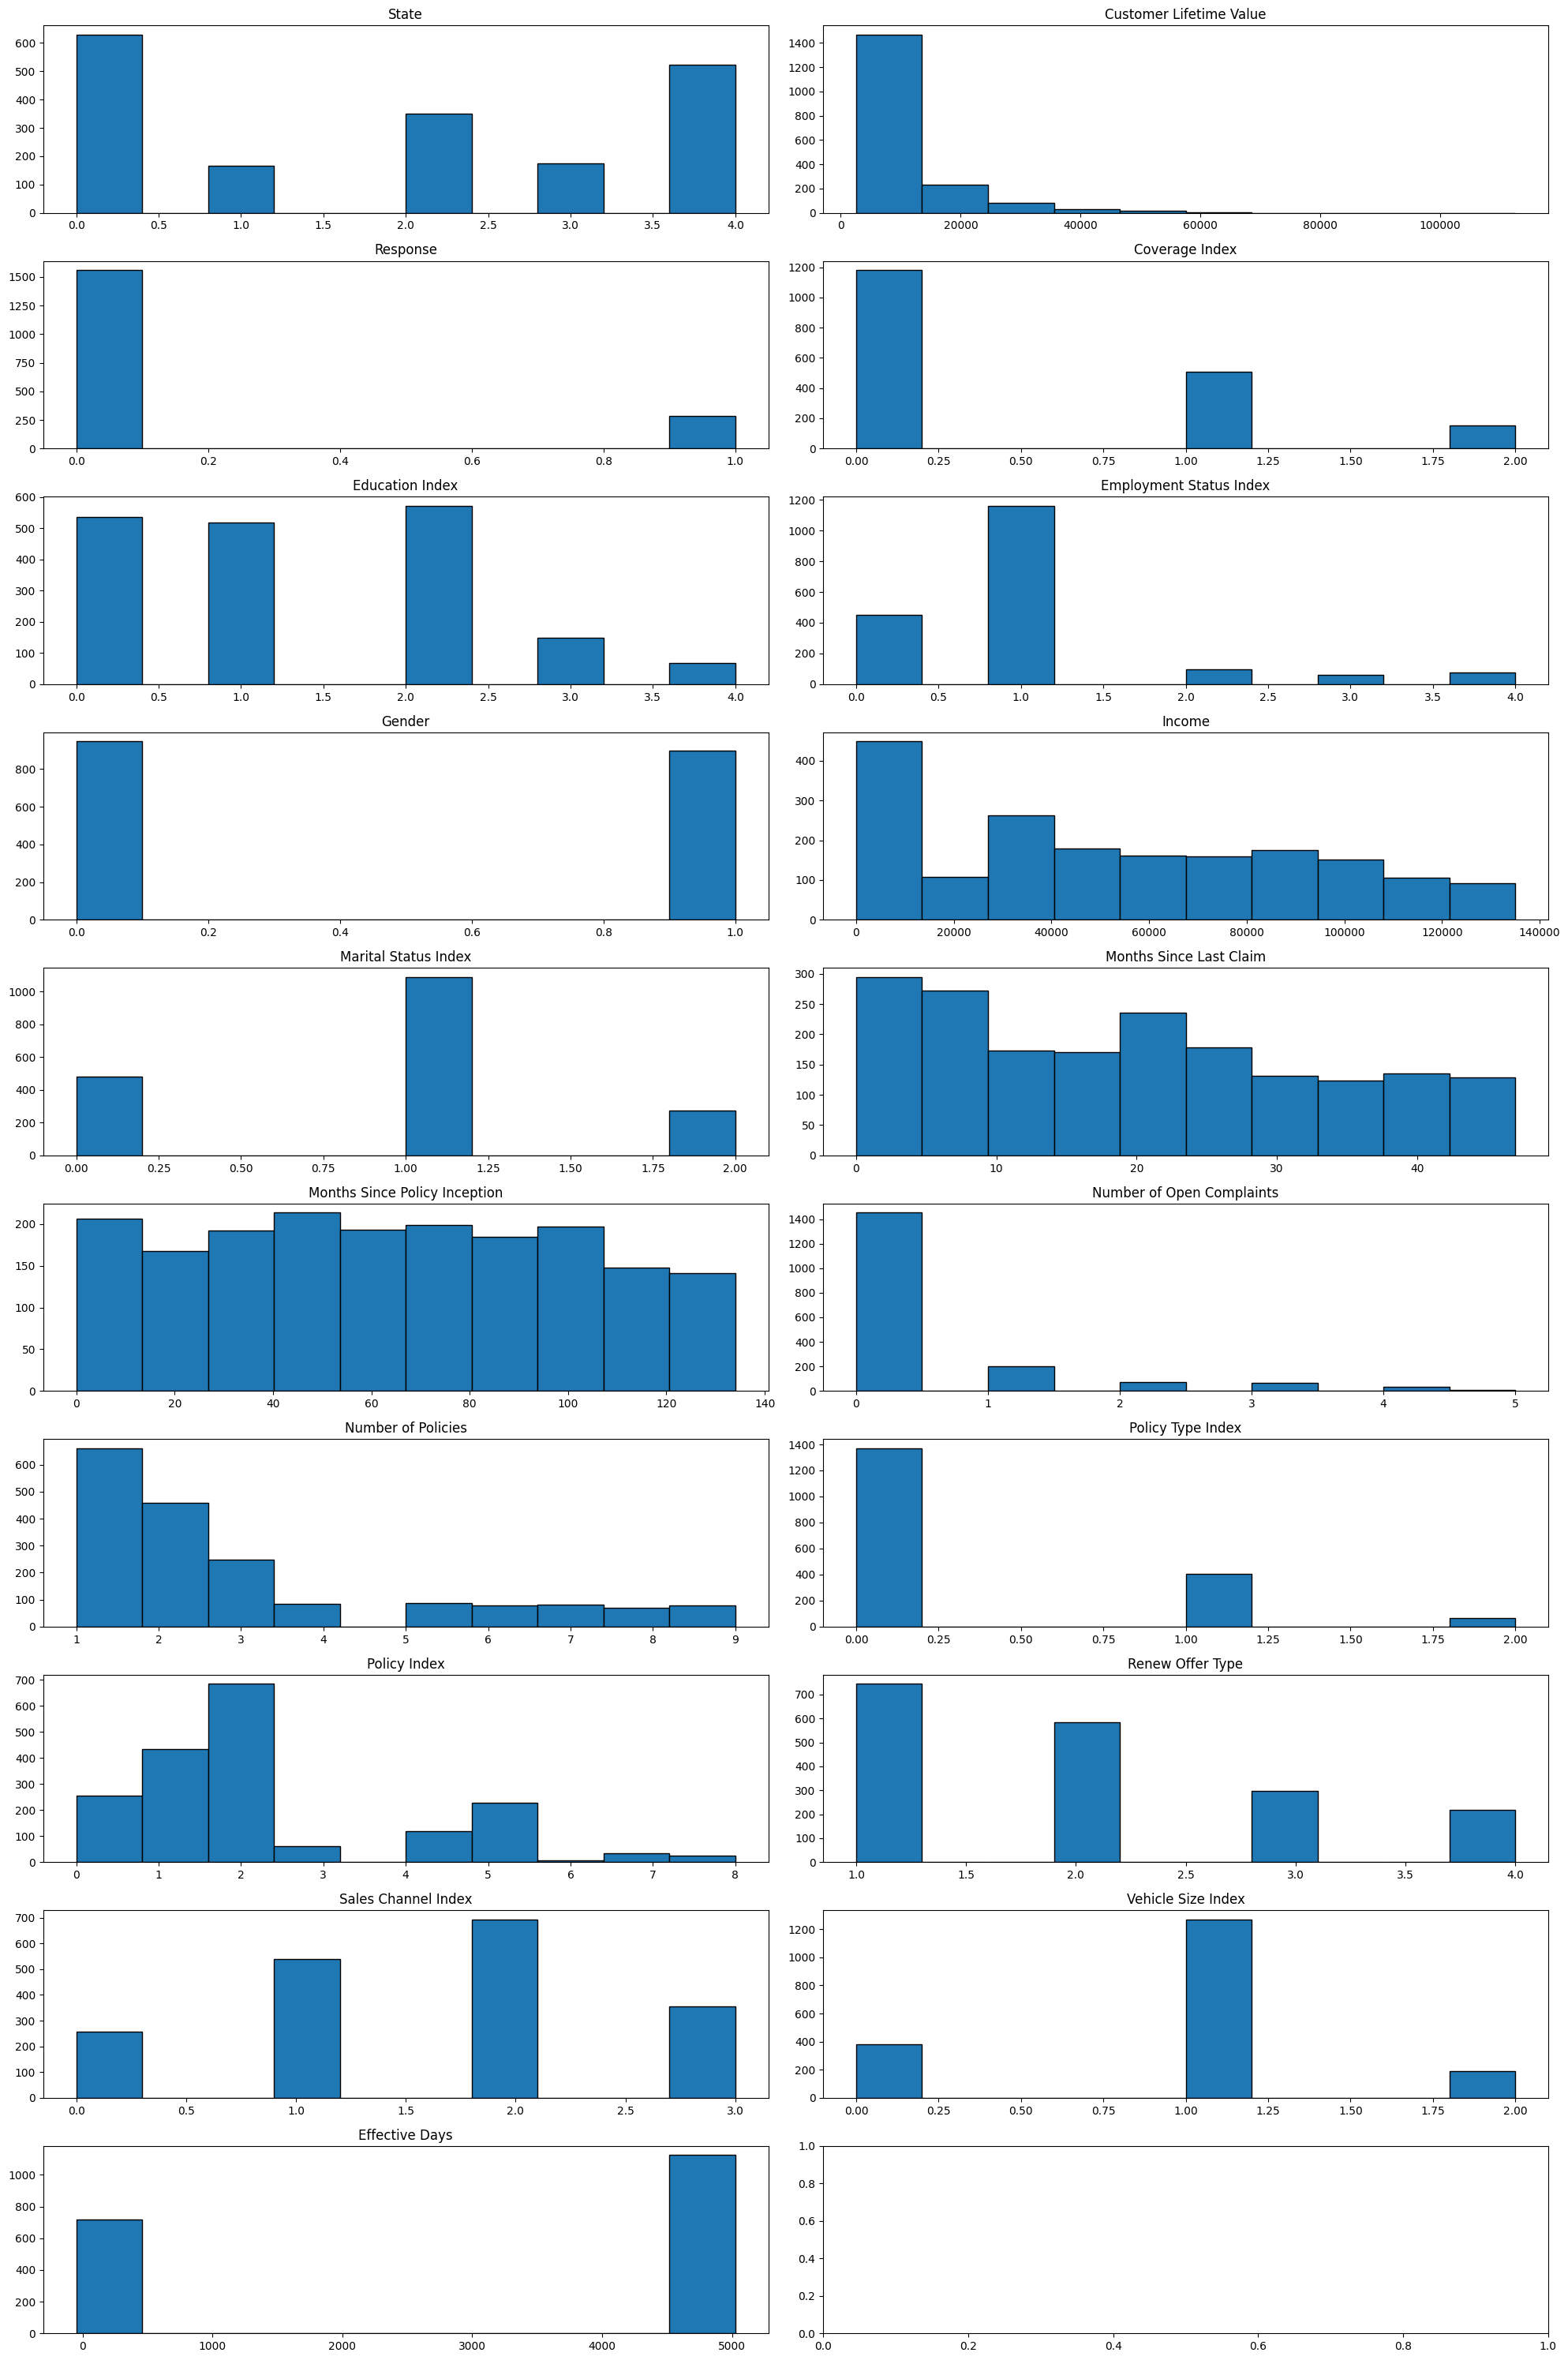

In [568]:
plot_df(df_to_run_test)

In [588]:
df_train.columns

Index(['State', 'Customer Lifetime Value', 'Response', 'Coverage Index',
       'Education Index', 'Employment Status Index', 'Gender', 'Income',
       'Marital Status Index', 'Months Since Last Claim',
       'Months Since Policy Inception', 'Number of Open Complaints',
       'Number of Policies', 'Policy Type Index', 'Policy Index',
       'Renew Offer Type', 'Sales Channel Index', 'Vehicle Size Index',
       'Claim over 1k', 'Effective Days'],
      dtype='object')

In [623]:
cols_to_drop = ["Response", "Gender", "Number of Open Complaints", "Policy Type Index", "Policy Index", "Sales Channel Index", "Vehicle Size Index"]
df_train_after_drop = df_train.drop(columns=cols_to_drop, axis=1)
df_train_after_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6390 entries, 900 to 7289
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   State                          6390 non-null   int64  
 1   Customer Lifetime Value        6390 non-null   float64
 2   Coverage Index                 6390 non-null   int64  
 3   Education Index                6390 non-null   int64  
 4   Employment Status Index        6390 non-null   int64  
 5   Income                         6390 non-null   int64  
 6   Marital Status Index           6390 non-null   int64  
 7   Months Since Last Claim        6390 non-null   int64  
 8   Months Since Policy Inception  6390 non-null   int64  
 9   Number of Policies             6390 non-null   int64  
 10  Renew Offer Type               6390 non-null   int64  
 11  Claim over 1k                  6390 non-null   int64  
 12  Effective Days                 6390 non-null  

In [624]:
new_X_resampled, new_Y_resampled = balance(df_train_after_drop)

Claim over 1k
0    5647
1    5647
Name: count, dtype: int64
State
   State  Claim over 1k  count
0      0              0    565
1      0              1    512
2      1              1    475
3      1              0    472
4      2              1   1681
5      2              0   1614
6      3              1   2104
7      3              0   1934
8      4              0   1062
9      4              1    875


Coverage Index
   Coverage Index  Claim over 1k  count
0               0              0   3529
1               0              1   2155
2               1              1   1933
3               1              0   1726
4               2              1   1559
5               2              0    392


Education Index
   Education Index  Claim over 1k  count
0                0              1   2228
1                0              0   1547
2                1              0   1719
3                1              1   1459
4                2              1   1665
5                2              0   1655
6                3              0    494
7                3              1    256
8                4              0    232
9                4              1     39


Employment Status Index
   Employment Status Index  Claim over 1k  count
0                        0              1   3165
1                        0              0   1234
2                        1              0   3719
3                        1              1   1864
4                        2              1    258
5                        2              0    254
6                        3              0    177
7                        3              1     96
8                        4              1    264
9                        4              0    263


Marital Status Index
   Marital Status Index  Claim over 1k  count
0                     0              1   3168
1                     0              0   1324
2                     1              0   3429
3                     1              1   1973
4                     2              0    894
5                     2              1    506


Months Since Last Claim
    Months Since Last Claim  Claim over 1k  count
0                         0              0    191
1                         0              1    171
2                         1              0    207
3                         1              1    194
4                         3              1    198
..                      ...            ...    ...
67                       45              0    109
68                       46              0    104
69                       46              1     94
70                       47              1    113
71                       47              0     89

[72 rows x 3 columns]


Months Since Policy Inception
     Months Since Policy Inception  Claim over 1k  count
0                                0              0     48
1                                0              1     44
2                                1              0     54
3                                1              1     53
4                                3              0     48
..                             ...            ...    ...
195                            131              1     15
196                            132              0     36
197                            132              1     20
198                            134              1     52
199                            134              0     42

[200 rows x 3 columns]


Number of Policies
    Number of Policies  Claim over 1k  count
0                    1              1   2131
1                    1              0   2003
2                    2              0   1436
3                    2              1   1409
4                    3              0    728
5                    3              1    562
6                    4              0    239
7                    4              1    235
8                    5              0    252
9                    5              1    216
10                   6              1    232
11                   6              0    228
12                   7              1    376
13                   7              0    254
14                   8              1    296
15                   8              0    234
16                   9              0    273
17                   9              1    190


Renew Offer Type
   Renew Offer Type  Claim over 1k  count
0                 1              1   2828
1                 1              0   2270
2                 2              0   1866
3                 2              1   1428
4                 3              0    872
5                 3              1    853
6                 4              0    639
7                 4              1    538


Effective Days
     Effective Days  Claim over 1k  count
0               -48              1    111
1               -48              0     87
2               -47              0     77
3               -47              1     49
4               -18              0     89
..              ...            ...    ...
113            5022              0     86
114            5023              1    130
115            5023              0     94
116            5024              1    107
117            5024              0     74

[118 rows x 3 columns]


<Figure size 3000x8000 with 0 Axes>

In [625]:
X_train, X_test, y_train, y_test = train_test_split(new_X_resampled, new_Y_resampled, test_size = 0.1, random_state = 42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)